In [1]:
%pip install --quiet transformers accelerate evaluate datasets peft

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import torch
import evaluate
import numpy as np
from peft import PeftModel, LoraConfig, get_peft_model
from transformers import (
    AutoModelForImageClassification,
    AutoImageProcessor,
    TrainingArguments,
    Trainer
)
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor
from datasets import load_dataset
from peft import PeftModel, LoraConfig, get_peft_model, PromptTuningConfig, PromptEncoderConfig, PrefixTuningConfig, AdaLoraConfig
from peft import (
    LoraConfig, AdaLoraConfig, PrefixTuningConfig, PromptTuningConfig,
    IA3Config, LoHaConfig, LoKrConfig, AdaptionPromptConfig
)
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from transformers import TrainerCallback


In [4]:

# Helper functions
def print_model_size(path):
    size = sum(os.path.getsize(f) for f in os.scandir(path))
    print(f"Model size: {(size / 1e6):.2f} MB")


def print_trainable_parameters(model, label):
    parameters, trainable = 0, 0
    for _, p in model.named_parameters():
        parameters += p.numel()
        trainable += p.numel() if p.requires_grad else 0
    print(f"{label} trainable parameters: {trainable:,}/{parameters:,} ({100 * trainable / parameters:.2f}%)")


def split_dataset(dataset):
    return dataset.train_test_split(test_size=0.1).values()


def get_label_key(dataset):
    # Function to get the correct label key
    for key, feature in dataset.features.items():
        print(f"Checking key: {key}, dtype: {feature.dtype}")
        if feature.dtype == 'int64' or hasattr(feature, 'names'):
            return key
    print("Available features:", dataset.features)
    raise ValueError("No suitable label key found in the dataset.")



def create_label_mappings(dataset, label_key):
    label2id, id2label = dict(), dict()
    for i, label in enumerate(dataset.features[label_key].names):
        label2id[label] = i
        id2label[i] = label
    return label2id, id2label


def preprocess(batch):
    batch["pixel_values"] = [preprocess_pipeline(image.convert("RGB")) for image in batch.get("image", batch.get("img"))]
    return batch

def data_collate(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # Handle different label keys for dataset1 and dataset2
    labels = torch.tensor([example.get("labels", example.get("label")) for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}



def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = metric_accuracy.compute(predictions=predictions, references=eval_pred.label_ids)
    f1 = metric_f1.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")
    precision = metric_precision.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")
    recall = metric_recall.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")

    # Extract the scalar values from the metric results
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"]
    }



def get_base_model(label2id, id2label):
    return AutoModelForImageClassification.from_pretrained(
        model_checkpoint,
        label2id=label2id,
        id2label=id2label,
        ignore_mismatched_sizes=True,
    )


def build_finetune_model(label2id, id2label, adapter_name):
    model = get_base_model(label2id, id2label)
    print_trainable_parameters(model, label="Base model")

    adapter_config = adapter_configs.get(adapter_name)
    if adapter_config is None:
        raise ValueError(f"Unsupported adapter: {adapter_name}")

    peft_config = adapter_config["config"]
    peft_model = get_peft_model(model, peft_config)
    print_trainable_parameters(peft_model, label=f"{adapter_name.upper()} adapter")

    return peft_model


def build_inference_model(label2id, id2label, adapter_path):
    model = get_base_model(label2id, id2label)
    return PeftModel.from_pretrained(model, adapter_path)


def predict(image, model, image_processor):
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
    class_index = logits.argmax(-1).item()
    return model.config.id2label[class_index]


class MetricsCallback(TrainerCallback):
    def __init__(self, metrics_dict):
        self.metrics_dict = metrics_dict
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_local_process_zero:
            epoch = state.epoch
            for metric in ['accuracy', 'precision', 'recall', 'f1']:
                if f'eval_{metric}' in logs:
                    self.metrics_dict['epoch'].append(epoch)
                    self.metrics_dict[metric].append(logs[f'eval_{metric}'])

def plot_metrics(metrics_data, model_name):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Metrics Comparison for {model_name}', fontsize=16)

    for i, metric in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        for adapter, data in metrics_data.items():
            epochs = np.array(data['epoch'])
            metric_values = np.array(data[metric])

            # Check for mismatch and align lengths if necessary
            if len(epochs) != len(metric_values):
                min_length = min(len(epochs), len(metric_values))
                epochs = epochs[:min_length]
                metric_values = metric_values[:min_length]

            # Sort the data points by epoch
            sort_indices = np.argsort(epochs)
            epochs = epochs[sort_indices]
            metric_values = metric_values[sort_indices]

            ax.plot(epochs, metric_values, label=adapter, marker='o')

        ax.set_title(metric.capitalize())
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_metrics_comparison.png')
    plt.show()
    plt.close()



In [5]:

# Dataset and model configuration
model_checkpoint = "google/vit-base-patch16-224-in21k"
batch_size = 128

metric_accuracy = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint, use_fast=True)

# Preprocess pipeline
preprocess_pipeline = Compose([
    Resize(image_processor.size["height"]),
    CenterCrop(image_processor.size["height"]),
    ToTensor(),
    Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

# Load and preprocess datasets
dataset1 = load_dataset("Bingsu/Human_Action_Recognition", split="train[:1000]")
dataset2 = load_dataset("SatwikKambham/uc_merced_land_use", split="train[:1000]")

dataset1_label_key = get_label_key(dataset1)
dataset2_label_key = get_label_key(dataset2)


dataset1_train, dataset1_test = split_dataset(dataset1)
dataset2_train, dataset2_test = split_dataset(dataset2)
# Pass the label key to the create_label_mappings function
dataset1_label2id, dataset1_id2label = create_label_mappings(dataset1, dataset1_label_key)
dataset2_label2id, dataset2_id2label = create_label_mappings(dataset2, dataset2_label_key)


Checking key: image, dtype: PIL.Image.Image
Checking key: labels, dtype: int64
Checking key: img, dtype: PIL.Image.Image
Checking key: label, dtype: int64


In [6]:
adapter_configs = {
    "lora": {
        "peft_type": "LORA",
        "config": LoraConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=8,  # Lower value to reduce trainable parameters
            lora_alpha=32,  # Higher scaling factor for more expressiveness
            target_modules=["query", "value", "key"],  # Include key layer as well
            lora_dropout=0.05,  # Slightly lower dropout for regularization
            bias="none"
        )
    },

    "adalora": {
        "peft_type": "ADALORA",
        "config": AdaLoraConfig(
            task_type="IMAGE_CLASSIFICATION",
            init_r=8,  # Start with a smaller rank for dynamic adaptation
            lora_alpha=32,  # Higher scaling factor
            target_modules=["query", "value", "key"],  # Include key layer
            lora_dropout=0.05,  # Slightly lower dropout for regularization
        )
    },

    "ia3": {
        "peft_type": "IA3",
        "config": IA3Config(
            task_type="IMAGE_CLASSIFICATION",
            target_modules=["query", "value", "key","output.dense", "intermediate.dense"],  # Include key and dense layers
            feedforward_modules=["output.dense", "intermediate.dense"],  # Additional scaling for feedforward layers
        )
    },

    "loha": {
        "peft_type": "LOHA",
        "config": LoHaConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=8,  # Lower value for fewer trainable parameters
            alpha=32,  # Higher scaling factor for more expressiveness
            target_modules=["query", "value", "key"],  # Include key layer
        )
    },

    "lokr": {
        "peft_type": "LOKR",
        "config": LoKrConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=8,  # Lower rank for fewer trainable parameters
            alpha=32,  # Higher scaling factor
            target_modules=["query", "value", "key"],  # Include key layer
        )
    }
}

In [7]:
model_checkpoint = "google/vit-base-patch16-224-in21k"
batch_size = 64

config = {
    "model1": {
        "train_data": dataset1_train,
        "test_data": dataset1_test,
        "label2id": dataset1_label2id,
        "id2label": dataset1_id2label,
        "epochs": 20,
        "path": "./finetuned-model1",
    },
    "model2": {
        "train_data": dataset2_train,
        "test_data": dataset2_test,
        "label2id": dataset2_label2id,
        "id2label": dataset2_id2label,
        "epochs": 20,
        "path": "./finetuned-model2",
    },
}

# Set transformations for datasets
for cfg in config.values():
    cfg["train_data"].set_transform(preprocess)
    cfg["test_data"].set_transform(preprocess)

# Training arguments
training_arguments = TrainingArguments(
    output_dir="./model-checkpoints",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    fp16=True,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    label_names=["labels"],
    report_to = 'none',
    num_train_epochs = 20,
)



In [8]:
import torch
metrics_data = {
    model_name: {
        adapter: {'epoch': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []} 
        for adapter in adapter_configs
    } for model_name in config.keys()
}

for adapter_name, adapter_config in adapter_configs.items():
    for model_name, cfg in config.items():
        training_arguments.num_train_epochs = cfg["epochs"]

        # Create a MetricsCallback instance for this run
        metrics_callback = MetricsCallback(metrics_data[model_name][adapter_name])

        trainer = Trainer(
            model=build_finetune_model(cfg["label2id"], cfg["id2label"], adapter_name),
            args=training_arguments,
            train_dataset=cfg["train_data"],
            eval_dataset=cfg["test_data"],
            tokenizer=image_processor,
            compute_metrics=compute_metrics,
            data_collator=data_collate,
            callbacks=[metrics_callback]  # Add the metrics callback
        )

        # Training
        results = trainer.train()
        
        torch.cuda.empty_cache()

        # Evaluation
        evaluation_results = trainer.evaluate(cfg["test_data"])
        print(f"{adapter_name} - {model_name} Evaluation Metrics: {evaluation_results}")

        # Collect final evaluation metrics
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            metrics_data[model_name][adapter_name]['epoch'].append(cfg["epochs"])
            metrics_data[model_name][adapter_name][metric].append(evaluation_results[f'eval_{metric}'])
            
        torch.cuda.empty_cache()

        # Save the fine-tuned model
        adapter_path = f"{cfg['path']}-{adapter_name}"
        trainer.save_model(adapter_path)
        print_model_size(adapter_path)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model trainable parameters: 85,810,191/85,810,191 (100.00%)
LORA adapter trainable parameters: 442,368/86,252,559 (0.51%)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.673600,2.649444,0.140000,0.119095,0.130499,0.140000
2,2.524500,2.476630,0.380000,0.334957,0.376730,0.380000
3,2.410400,2.282751,0.480000,0.410781,0.503810,0.480000
4,2.184700,2.136795,0.520000,0.448253,0.618933,0.520000
5,1.988200,1.969930,0.560000,0.493501,0.638990,0.560000
6,1.899500,1.857448,0.620000,0.545750,0.659159,0.620000
7,1.678600,1.787477,0.610000,0.551940,0.631647,0.610000
8,1.821700,1.703354,0.640000,0.587487,0.667036,0.640000
9,1.492300,1.644475,0.630000,0.564697,0.634296,0.630000
10,1.532500,1.594405,0.640000,0.581509,0.622678,0.640000


lora - model1 Evaluation Metrics: {'eval_loss': 1.4052177667617798, 'eval_accuracy': 0.71, 'eval_f1': 0.6875577340369025, 'eval_precision': 0.7139346405228757, 'eval_recall': 0.71, 'eval_runtime': 0.9265, 'eval_samples_per_second': 107.929, 'eval_steps_per_second': 1.079, 'epoch': 20.0}
Model size: 1.79 MB


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model trainable parameters: 85,814,805/85,814,805 (100.00%)
LORA adapter trainable parameters: 442,368/86,257,173 (0.51%)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.974000,2.864772,0.380000,0.363429,0.384262,0.380000
2,2.598000,2.484289,0.590000,0.538262,0.590832,0.590000
3,2.254000,2.220509,0.550000,0.486489,0.526093,0.550000
4,1.995300,1.973242,0.750000,0.720027,0.853924,0.750000
5,1.687200,1.756698,0.850000,0.842759,0.890102,0.850000
6,1.638400,1.559320,0.870000,0.848367,0.920632,0.870000
7,1.419600,1.418935,0.900000,0.889052,0.940000,0.900000
8,1.210300,1.299684,0.970000,0.970481,0.975354,0.970000
9,1.155300,1.209543,0.980000,0.979909,0.983333,0.980000
10,1.117000,1.138713,0.990000,0.990000,0.990909,0.990000


lora - model2 Evaluation Metrics: {'eval_loss': 1.0627872943878174, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 0.9483, 'eval_samples_per_second': 105.454, 'eval_steps_per_second': 1.055, 'epoch': 20.0}
Model size: 1.79 MB


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model trainable parameters: 85,810,191/85,810,191 (100.00%)
ADALORA adapter trainable parameters: 442,656/86,252,883 (0.51%)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.741600,2.729431,0.100000,0.078068,0.134500,0.100000
2,2.727400,2.727929,0.100000,0.077908,0.134349,0.100000
3,2.713200,2.722848,0.100000,0.078681,0.134971,0.100000
4,2.708100,2.712351,0.120000,0.098487,0.130405,0.120000
5,2.698300,2.694737,0.140000,0.116695,0.144475,0.140000
6,2.671800,2.670285,0.190000,0.154026,0.156775,0.190000
7,2.664100,2.640188,0.260000,0.197051,0.225357,0.260000
8,2.627500,2.606211,0.300000,0.229429,0.339513,0.300000
9,2.578800,2.567446,0.370000,0.316547,0.391957,0.370000
10,2.562100,2.523620,0.400000,0.352549,0.436378,0.400000


adalora - model1 Evaluation Metrics: {'eval_loss': 2.2962310314178467, 'eval_accuracy': 0.54, 'eval_f1': 0.4639689082993213, 'eval_precision': 0.5191349206349206, 'eval_recall': 0.54, 'eval_runtime': 0.9223, 'eval_samples_per_second': 108.429, 'eval_steps_per_second': 1.084, 'epoch': 20.0}
Model size: 1.80 MB


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model trainable parameters: 85,814,805/85,814,805 (100.00%)
ADALORA adapter trainable parameters: 442,656/86,257,497 (0.51%)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.034600,3.041410,0.040000,0.051111,0.090000,0.040000
2,3.044100,3.034440,0.050000,0.059683,0.097273,0.050000
3,3.007800,3.013127,0.120000,0.156125,0.330000,0.120000
4,2.968900,2.972786,0.170000,0.198682,0.312863,0.170000
5,2.904500,2.917289,0.290000,0.277166,0.316786,0.290000
6,2.885800,2.847391,0.370000,0.324105,0.358726,0.370000
7,2.782100,2.760801,0.400000,0.338534,0.393109,0.400000
8,2.661600,2.668890,0.420000,0.348905,0.411684,0.420000
9,2.563000,2.585371,0.400000,0.325220,0.449658,0.400000
10,2.476500,2.512839,0.410000,0.330585,0.459718,0.410000


adalora - model2 Evaluation Metrics: {'eval_loss': 2.100152015686035, 'eval_accuracy': 0.76, 'eval_f1': 0.7453969696969698, 'eval_precision': 0.8598253968253968, 'eval_recall': 0.76, 'eval_runtime': 0.9722, 'eval_samples_per_second': 102.857, 'eval_steps_per_second': 1.029, 'epoch': 20.0}
Model size: 1.80 MB


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model trainable parameters: 85,810,191/85,810,191 (100.00%)
IA3 adapter trainable parameters: 82,944/85,893,135 (0.10%)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.733800,2.714082,0.120000,0.086555,0.102262,0.120000
2,2.700300,2.701031,0.150000,0.116035,0.128797,0.150000
3,2.678700,2.688888,0.160000,0.129247,0.145016,0.160000
4,2.662100,2.678095,0.140000,0.118638,0.138576,0.140000
5,2.649000,2.667667,0.200000,0.169267,0.173748,0.200000
6,2.634000,2.657679,0.220000,0.183168,0.184370,0.220000
7,2.636600,2.648443,0.240000,0.203682,0.198886,0.240000
8,2.622400,2.640174,0.280000,0.244307,0.268237,0.280000
9,2.592500,2.632589,0.280000,0.254873,0.286261,0.280000
10,2.608500,2.625660,0.280000,0.256541,0.289333,0.280000


ia3 - model1 Evaluation Metrics: {'eval_loss': 2.5960137844085693, 'eval_accuracy': 0.36, 'eval_f1': 0.34413075813075816, 'eval_precision': 0.4424458874458875, 'eval_recall': 0.36, 'eval_runtime': 0.9025, 'eval_samples_per_second': 110.809, 'eval_steps_per_second': 1.108, 'epoch': 20.0}
Model size: 0.35 MB


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model trainable parameters: 85,814,805/85,814,805 (100.00%)
IA3 adapter trainable parameters: 82,944/85,897,749 (0.10%)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.006200,2.998169,0.110000,0.145437,0.327912,0.110000
2,2.972100,2.958491,0.190000,0.223177,0.351250,0.190000
3,2.893100,2.921913,0.250000,0.267023,0.324212,0.250000
4,2.858200,2.889174,0.300000,0.307430,0.338731,0.300000
5,2.826900,2.858864,0.400000,0.423431,0.517976,0.400000
6,2.837600,2.830768,0.470000,0.474011,0.552009,0.470000
7,2.801600,2.805200,0.520000,0.517062,0.596030,0.520000
8,2.746800,2.781919,0.580000,0.581127,0.676583,0.580000
9,2.709000,2.760677,0.590000,0.590516,0.684730,0.590000
10,2.717100,2.741073,0.620000,0.619903,0.709810,0.620000


ia3 - model2 Evaluation Metrics: {'eval_loss': 2.6438961029052734, 'eval_accuracy': 0.84, 'eval_f1': 0.8372934472934471, 'eval_precision': 0.8650140056022408, 'eval_recall': 0.84, 'eval_runtime': 0.9215, 'eval_samples_per_second': 108.519, 'eval_steps_per_second': 1.085, 'epoch': 20.0}
Model size: 0.35 MB


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model trainable parameters: 85,810,191/85,810,191 (100.00%)
LOHA adapter trainable parameters: 884,736/86,694,927 (1.02%)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.739700,2.725038,0.100000,0.078575,0.135778,0.100000
2,2.717300,2.716349,0.120000,0.095395,0.126450,0.120000
3,2.694600,2.701687,0.150000,0.119484,0.144715,0.150000
4,2.676000,2.681092,0.160000,0.128224,0.142454,0.160000
5,2.649800,2.653955,0.200000,0.160218,0.162987,0.200000
6,2.617700,2.620676,0.260000,0.216699,0.297123,0.260000
7,2.593400,2.581600,0.360000,0.325865,0.422500,0.360000
8,2.546800,2.536768,0.480000,0.458343,0.530833,0.480000
9,2.484200,2.489212,0.520000,0.491886,0.580542,0.520000
10,2.455100,2.446493,0.520000,0.472339,0.518518,0.520000


loha - model1 Evaluation Metrics: {'eval_loss': 2.3332314491271973, 'eval_accuracy': 0.56, 'eval_f1': 0.5017642110358005, 'eval_precision': 0.5783928571428572, 'eval_recall': 0.56, 'eval_runtime': 0.9835, 'eval_samples_per_second': 101.679, 'eval_steps_per_second': 1.017, 'epoch': 20.0}
Model size: 3.57 MB


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model trainable parameters: 85,814,805/85,814,805 (100.00%)
LOHA adapter trainable parameters: 884,736/86,699,541 (1.02%)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.024900,3.013625,0.070000,0.069761,0.115133,0.070000
2,2.992300,2.984063,0.180000,0.144335,0.166515,0.180000
3,2.959300,2.937276,0.270000,0.217293,0.449857,0.270000
4,2.898300,2.874650,0.350000,0.319625,0.567305,0.350000
5,2.772100,2.797930,0.450000,0.433501,0.641868,0.450000
6,2.736100,2.708742,0.550000,0.523486,0.742259,0.550000
7,2.641200,2.612617,0.630000,0.605114,0.815000,0.630000
8,2.551900,2.515871,0.720000,0.713307,0.868362,0.720000
9,2.391200,2.421288,0.760000,0.746199,0.874678,0.760000
10,2.337100,2.330791,0.790000,0.772092,0.882773,0.790000


loha - model2 Evaluation Metrics: {'eval_loss': 1.9909480810165405, 'eval_accuracy': 0.88, 'eval_f1': 0.8548974358974359, 'eval_precision': 0.9325, 'eval_recall': 0.88, 'eval_runtime': 1.0354, 'eval_samples_per_second': 96.581, 'eval_steps_per_second': 0.966, 'epoch': 20.0}
Model size: 3.57 MB


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model trainable parameters: 85,810,191/85,810,191 (100.00%)
LOKR adapter trainable parameters: 39,168/85,849,359 (0.05%)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.713300,2.712802,0.040000,0.035753,0.033788,0.040000
2,2.734900,2.710012,0.050000,0.042891,0.039262,0.050000
3,2.715000,2.706823,0.060000,0.048831,0.043333,0.060000
4,2.711200,2.703371,0.060000,0.048114,0.042338,0.060000
5,2.712500,2.699488,0.060000,0.048114,0.042338,0.060000
6,2.691300,2.695171,0.060000,0.048572,0.042974,0.060000
7,2.664000,2.690529,0.090000,0.071747,0.062500,0.090000
8,2.699700,2.685703,0.090000,0.072126,0.063660,0.090000
9,2.701500,2.680777,0.090000,0.072792,0.064910,0.090000
10,2.670000,2.675848,0.080000,0.062679,0.056061,0.080000


lokr - model1 Evaluation Metrics: {'eval_loss': 2.6460225582122803, 'eval_accuracy': 0.16, 'eval_f1': 0.13566968703810808, 'eval_precision': 0.13994337194337192, 'eval_recall': 0.16, 'eval_runtime': 0.9935, 'eval_samples_per_second': 100.655, 'eval_steps_per_second': 1.007, 'epoch': 20.0}
Model size: 0.18 MB


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model trainable parameters: 85,814,805/85,814,805 (100.00%)
LOKR adapter trainable parameters: 39,168/85,853,973 (0.05%)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.027300,3.019673,0.070000,0.070925,0.116594,0.070000
2,3.008300,3.009884,0.080000,0.076381,0.120286,0.080000
3,3.017700,2.998850,0.120000,0.106594,0.144094,0.120000
4,2.998600,2.986828,0.170000,0.150848,0.257454,0.170000
5,2.952300,2.973850,0.210000,0.178958,0.292083,0.210000
6,2.951300,2.959994,0.250000,0.222914,0.398321,0.250000
7,2.947900,2.945510,0.270000,0.230058,0.480889,0.270000
8,2.934400,2.930643,0.280000,0.241759,0.496111,0.280000
9,2.899600,2.915643,0.300000,0.278408,0.465388,0.300000
10,2.889900,2.900800,0.310000,0.290474,0.490363,0.310000


lokr - model2 Evaluation Metrics: {'eval_loss': 2.81186580657959, 'eval_accuracy': 0.5, 'eval_f1': 0.5029377990430622, 'eval_precision': 0.6709636363636363, 'eval_recall': 0.5, 'eval_runtime': 1.0409, 'eval_samples_per_second': 96.07, 'eval_steps_per_second': 0.961, 'epoch': 20.0}
Model size: 0.18 MB


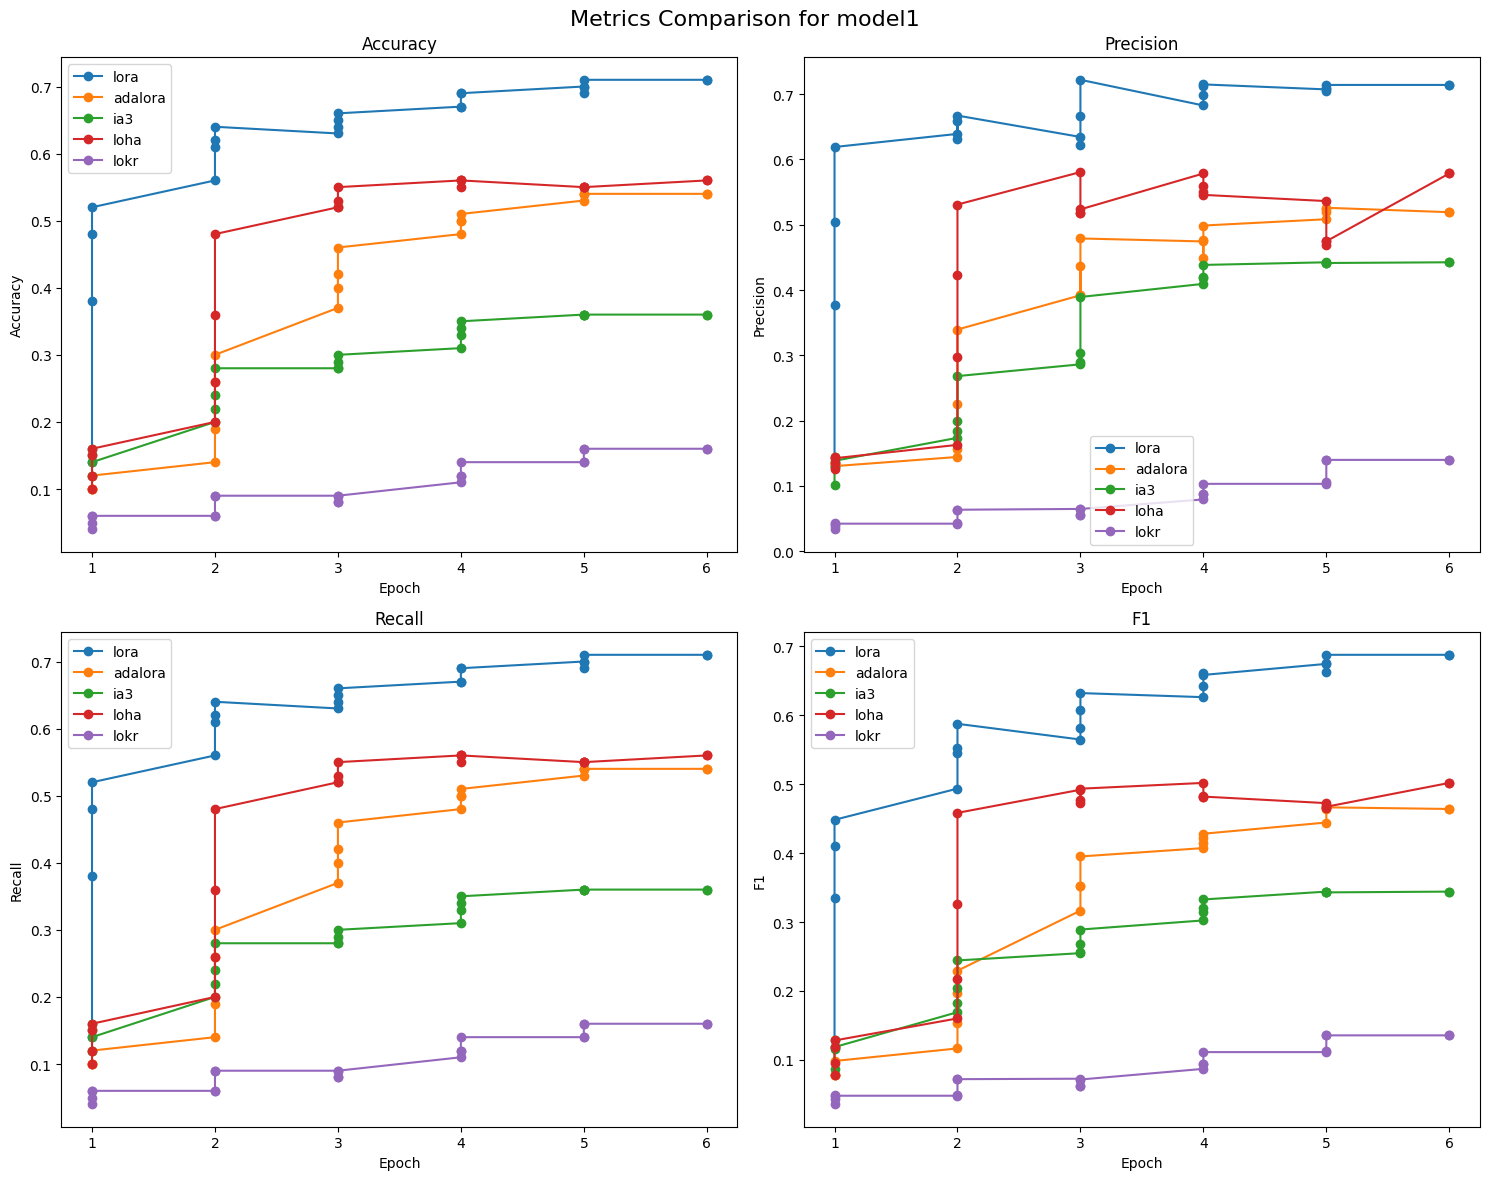

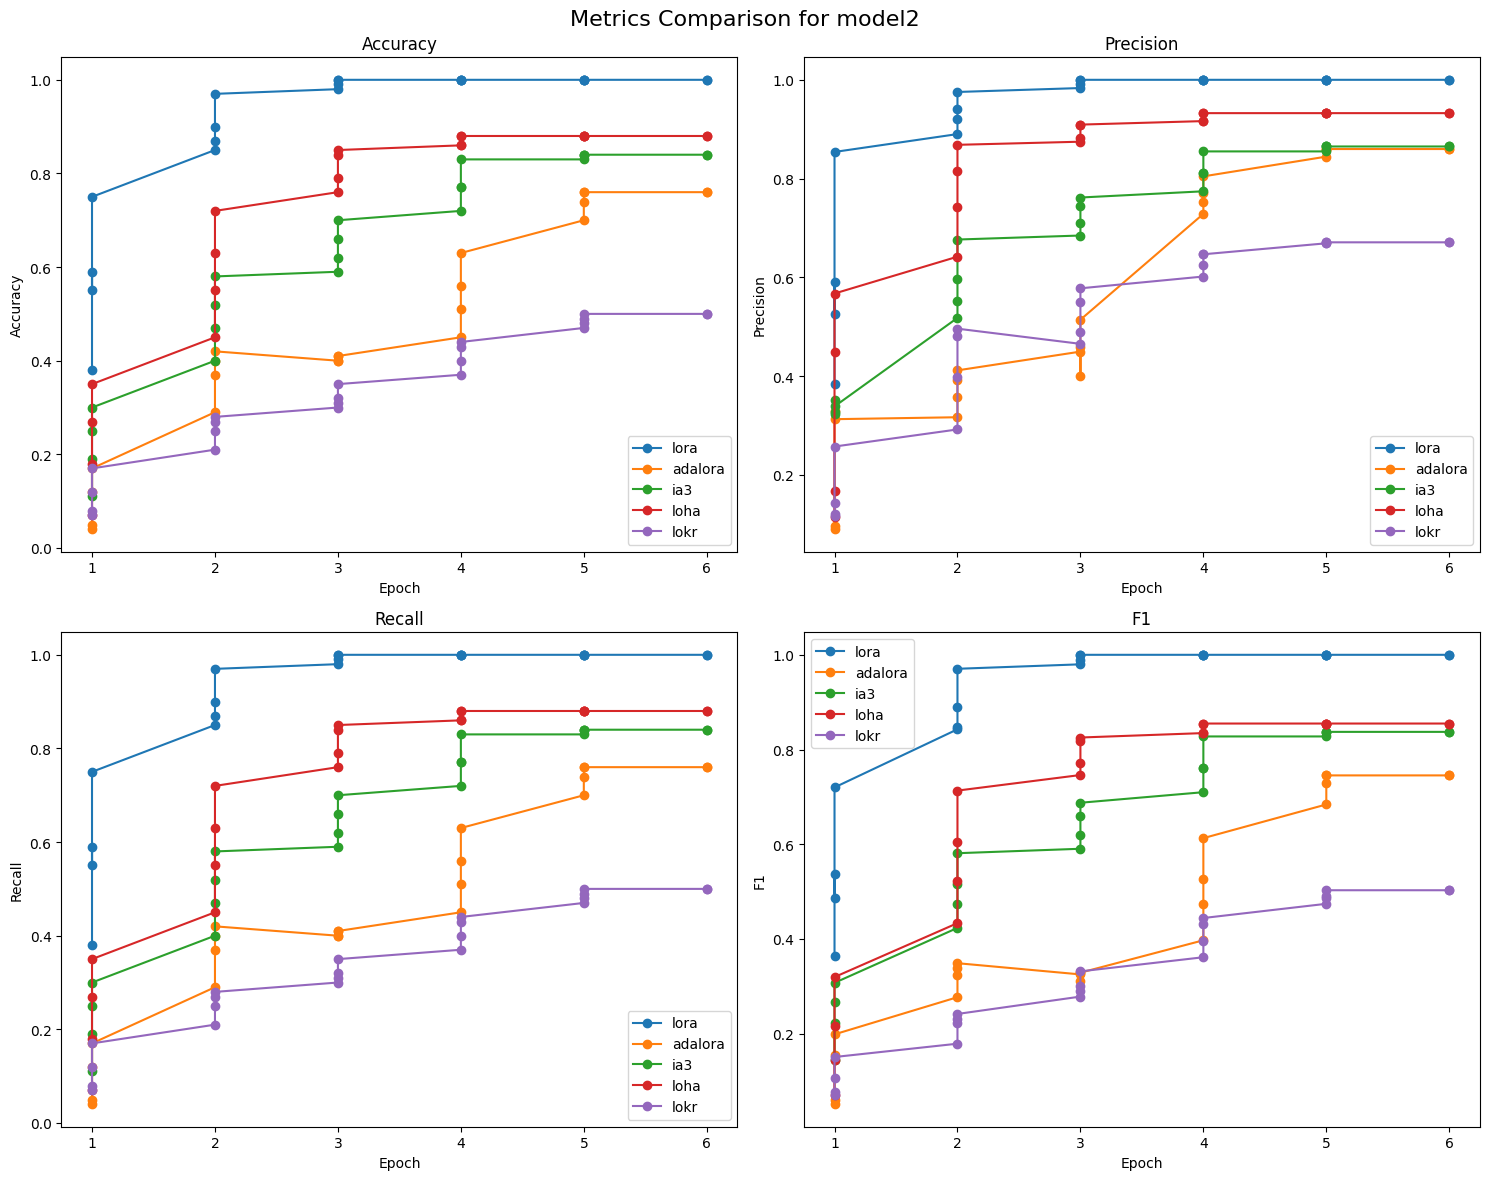

In [9]:
for dataset_name, data in metrics_data.items():
    plot_metrics(data, dataset_name)

In [12]:
import shutil

# Define the directory to zip
directory_to_zip = "/kaggle/working/"

# Define the output zip file path
output_zip_path = "/kaggle/working/working_directory.zip"

# Create a zip file of the directory
shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', directory_to_zip)

output_zip_path


'/kaggle/working/working_directory.zip'